All Imports

In [58]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import struct
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

Loading the dataset, Normalizing images, shuffling and resplitting for training, testing and validation.

In [65]:
def load_images(filename):
    with open(filename, 'rb') as f:
        magic, image_count, rowls, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape((image_count, rowls, cols,1)) # Last dimension is to be compatiable with tensorflow Conv2D input.
        data = data.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return data

def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, label_count = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def train_test_validation_split(X, Y, random_state,test_ratio=0.15, val_ratio=0.15):
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_ratio, random_state=random_state, stratify=Y)
    val_fraction_temp = val_ratio / (1 - test_ratio)  # Adjust validation size relative to the remaining data
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_fraction_temp, random_state=random_state, stratify=Y_temp) # This is done without using mode.fit()s validation split because it's not stratified.
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

# Loading with original split with a reshape.
try:
    init_train_images = load_images('dataset/train-images.idx3-ubyte')
    init_train_labels = load_labels('dataset/train-labels.idx1-ubyte')
    init_test_images = load_images('dataset/t10k-images.idx3-ubyte')
    init_test_labels = load_labels('dataset/t10k-labels.idx1-ubyte')
except Exception as e:
    print("Error loading data. Make sure the data files are present inside a 'dataset' folder with their original names:", e)

# Concatanation before shuffling and resplitting.

X = np.concatenate([init_train_images, init_test_images])
Y = np.concatenate([init_train_labels, init_test_labels])

# Randomisation seed for reproducibility
random_state = 42

# Shuffle and split.
x_train, x_test, x_val, y_train, y_test, y_val = train_test_validation_split(X, Y,random_state)

print(f"Training  Set: {x_train.shape}, {y_train.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")
print(f"Validation Set: {x_val.shape}, {y_val.shape}")

Training  Set: (49000, 28, 28, 1), (49000,)
Test set: (10500, 28, 28, 1), (10500,)
Validation Set: (10500, 28, 28, 1), (10500,)


Neural Network Architecture

In [60]:
model = keras.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

Learning Rate, Loss Function and Optimiser Specifications

In [61]:
learning_rate = 0.0005

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Learning and early stopping criterion.

In [62]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.0001)

history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size=512, verbose=2, callbacks=[early_stopping])

Epoch 1/20
96/96 - 10s - 102ms/step - accuracy: 0.7554 - loss: 0.8660 - val_accuracy: 0.9392 - val_loss: 0.2163
Epoch 2/20
96/96 - 7s - 70ms/step - accuracy: 0.9439 - loss: 0.1919 - val_accuracy: 0.9660 - val_loss: 0.1154
Epoch 3/20
96/96 - 7s - 70ms/step - accuracy: 0.9639 - loss: 0.1232 - val_accuracy: 0.9728 - val_loss: 0.0841
Epoch 4/20
96/96 - 7s - 72ms/step - accuracy: 0.9725 - loss: 0.0938 - val_accuracy: 0.9775 - val_loss: 0.0678
Epoch 5/20
96/96 - 7s - 70ms/step - accuracy: 0.9761 - loss: 0.0800 - val_accuracy: 0.9803 - val_loss: 0.0583
Epoch 6/20
96/96 - 7s - 69ms/step - accuracy: 0.9794 - loss: 0.0682 - val_accuracy: 0.9834 - val_loss: 0.0506
Epoch 7/20
96/96 - 7s - 68ms/step - accuracy: 0.9824 - loss: 0.0600 - val_accuracy: 0.9840 - val_loss: 0.0479
Epoch 8/20
96/96 - 7s - 68ms/step - accuracy: 0.9832 - loss: 0.0552 - val_accuracy: 0.9846 - val_loss: 0.0468
Epoch 9/20
96/96 - 6s - 67ms/step - accuracy: 0.9851 - loss: 0.0492 - val_accuracy: 0.9856 - val_loss: 0.0419
Epoch 10

Model Evaluation and Performance metrics

In [63]:
# evaluation on the test set.
y_pred = model.predict(x_test).argmax(axis=1)

#performance metrics (precision/recall and F1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)




329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Precision: 0.9913396169274331
Recall: 0.9913333333333333
F1-score: 0.9913324896481891


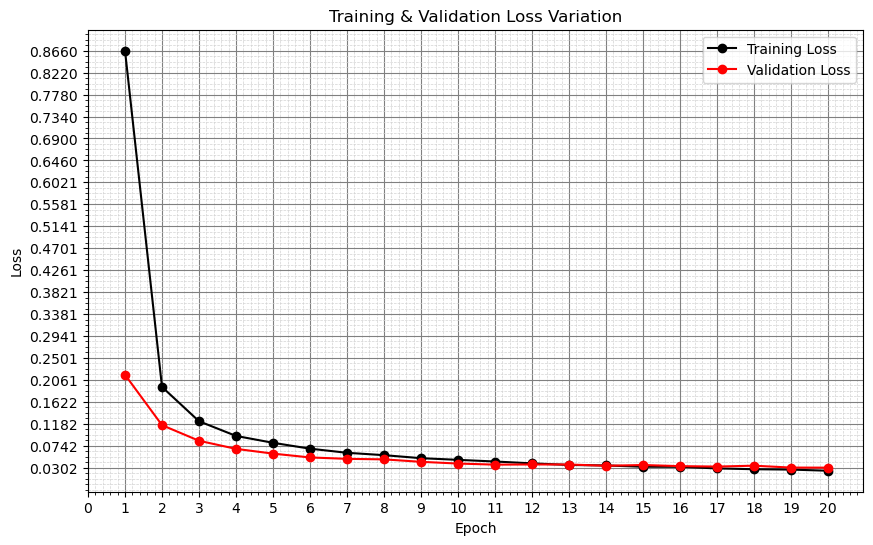

In [64]:

plt.figure(figsize=(10, 6))

# Plot training & validation loss
epochs = range(1, len(history.history['loss']) + 1) 

plt.plot(epochs, history.history['loss'], label='Training Loss', linestyle='-', marker='o', color='black')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o', color='red')

plt.title('Training & Validation Loss Variation')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# making grid and axis more detailed.
plt.xticks(np.arange(0, len(history.history['loss'])+1, 1))  # one tick per epoch
plt.yticks(np.linspace(min(history.history['val_loss']), 
                       max(history.history['loss']), 20))  # 20 y-ticks between min & max
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8, color='gray')
plt.grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')

# Legend
plt.legend()
plt.show()
